## C S 329E HW 10

# Clustering with DBSCAN

## Jeremy Ulfohn, pair 38

As we discussed in lecture DBSCAN creates clusters based on the density of the points in the vicinity of the data.  Using small example data sets, we will implement both algorithms and visualize the results.

Even though the example data is small and 2 dimensional, write your helper functions to not assume a 2-D data set.  Your plotting code can reference the `x` and `y` column names from the sample data directly. 

Note that I have added a one or two lines of code to the questions to test your implementations. 

In [178]:
# Do not import anything else
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN # only on last problem

# DBSCAN

## Q1 Load the Density Data and try K-means

Load in the data provided `data_dbscan.csv`, cluster it with k-means algorithm with $k=2$ and visualize the results with a scatter plot, where the color indicates cluster membership. Label your axes, and give the plot a title. Use the [scikit-learn implementation of K-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

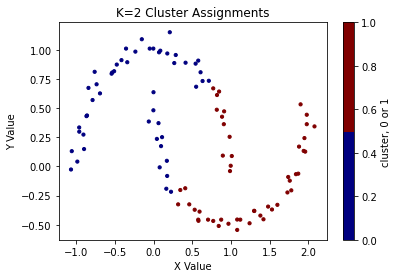

In [179]:
df_dbscan = pd.read_csv('https://gist.githubusercontent.com/yanyanzheng96/c4bf88d73e03305cc0e1abd0a8a8e185/raw/c15f0f59d06ccbe9e708eddaf361cc33c19b1ec6/data_dbscan.csv')
arr_dbscan = df_dbscan.to_numpy() # covert df to np.array. length 100

# Call k_means with k = 2
kmeans = KMeans(n_clusters=2, random_state=0).fit(arr_dbscan)
cluster_centers = kmeans.cluster_centers_ # get cluster centers for the 2 clusters, form[x, y]

# define and map colors for plot
colors = ['#DF2020', '#81DF20']
cluster_assignment = pd.Series(kmeans.fit_predict(arr_dbscan))

# concatenate cluster_assignment onto df_dbscan for plotting
df_dbscan['cluster, 0 or 1'] = cluster_assignment


# plot
fig, ax = plt.subplots()
cmap = plt.get_cmap('jet', 2)
df_dbscan.plot(kind='scatter', x='x', y='y', s=10, c='cluster, 0 or 1', colormap=cmap, ax=ax)
# title and axis labels
plt.title("K=2 Cluster Assignments")
plt.xlabel("X Value")
plt.ylabel("Y Value")
# plotting cluster centers not required

# reset df_dbscan to original
df_dbscan = pd.read_csv('https://gist.githubusercontent.com/yanyanzheng96/c4bf88d73e03305cc0e1abd0a8a8e185/raw/c15f0f59d06ccbe9e708eddaf361cc33c19b1ec6/data_dbscan.csv')



## Q2.2 Write function to Implement Range Query

Using the [pseudo-code](https://en.wikipedia.org/wiki/DBSCAN#Algorithm) on wikipedia, implement RangeQuery.

```
RangeQuery(DB, distFunc, Q, eps) {
    Neighbors N := empty list
    for each point P in database DB {                      /* Scan all points in the database */
        if distFunc(Q, P) ≤ eps then {                     /* Compute distance and check epsilon */
            N := N ∪ {P}                                   /* Add to result */
        }
    }
    return N
}
```

The "DB" parameter is a data frame, `df_data` containing all of the points in our data set, the "distFunc" is set as Euclidean distance thus should not be passed in, the point "Q", is represented by the index of the data frame, `q_index`, where `df_data.iloc[q_index]` is the actual point, and `eps` is a floating point value that indicates the radius from the point "Q" to search for neighbors.  The function will return the slice of `df_data` of all points within `eps` distance of "Q" (including "Q").  The indices on the slice should be preserved (do not reset_index).  

In [180]:
# INPUT: q_index: index of a point in the dataframe -- df_data.iloc[q_index] -- value at row
#       eps = radius from point Q
# OUTPUT: df -- slice of df_data with all points within eps of Q. PRESERVE index!
def range_query( df_data, q_index, eps ):
    # initialize list of indices of pts within eps of Q
    list_indices = []

    for index, row in df_data.iterrows():
        a = np.array(df_data.iloc[q_index]) # <==> np.array(Q)
        b = np.array(row)
        euclidean = np.linalg.norm(a - b) # here is where we assume the same dimension, d
        if euclidean <= eps: # check whether row is within eps
            list_indices.append(index)

    # return slice of df_data
    return df_data.iloc[list_indices]


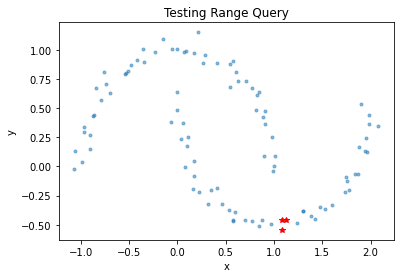

In [181]:
# Test it out
df_n = range_query( df_dbscan, 0, 0.1 )
plt.plot( df_dbscan['x'], df_dbscan['y'], '.', alpha = 0.5 )
plt.plot( df_n['x'], df_n['y'], 'r*')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Testing Range Query')
plt.show()

## Q2.3 Write a function to implement DBSCAN

Using the [pseudo-code](https://en.wikipedia.org/wiki/DBSCAN#Algorithm) on wikipedia, implement DBSCAN. This algorithm uses set notation, I found a handy summary on-line [here](http://www.math.cmu.edu/~bkell/21110-2010s/sets.html) if you need a refresher. 

```
DBSCAN(DB, distFunc, eps, minPts) {
    C := 0                                                  /* Cluster counter */
    for each point P in database DB {
        if label(P) ≠ undefined then continue               /* Previously processed in inner loop */
        Neighbors N := RangeQuery(DB, distFunc, P, eps)     /* Find neighbors */
        if |N| < minPts then {                              /* Density check */
            label(P) := Noise                               /* Label as Noise */
            continue
        }
        C := C + 1                                          /* next cluster label */
        label(P) := C                                       /* Label initial point */
        SeedSet S := N \ {P}                                /* Neighbors to expand */
        for each point Q in S {                             /* Process every seed point Q */
            if label(Q) = Noise then label(Q) := C          /* Change Noise to border point */
            if label(Q) ≠ undefined then continue           /* Previously processed (e.g., border point) */
            label(Q) := C                                   /* Label neighbor */
            Neighbors N := RangeQuery(DB, distFunc, Q, eps) /* Find neighbors */
            if |N| ≥ minPts then {                          /* Density check (if Q is a core point) */
                S := S ∪ N                                  /* Add new neighbors to seed set */
            }
        }
    }
}
```

The function should accept as parameters "DB", a data frame of points to be clustered, `df_data`, no distance function (assuming Euclidean distance), a floating point `eps` that defines the radius, and an integer `minPts`.  The function will return a series of cluster assignments of the same length as `df_data`. If the data is classified as noise, the cluster assignment is $0$, and all of the clusters will have a label of $1-k$, were $k$ is derived in the function and represents the total number of clusters found. 

Don't forget that [iterrows](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iterrows.html) is a lovely way to loop through a data frame. But if you modify the dataframe within the loop, it doesn't add more iterations to the loop.  For example, if you start with a dataframe of length $n$ and add $3$ rows, then the `iterrows` will stop after $n$ rows. For the inside loop, you'll need to use a native python list to dynamically grow the `SeedSet S`.  You can use the `extend` function to merge 2 lists together. For example:

```
x = [1,2,3]
y = [4,5,6]
x.extend(y) # sets x to the list [1, 2, 3, 4, 5, 6]
```

If you haven't used the [continue](https://docs.python.org/3/tutorial/controlflow.html) statement before, it can be useful in these situations, check out the link. 

Call `dbscan` with the `df_dbscan` data frame, `eps` set to 0.23, and `min_pts` set to 6 and save the results to `s_cluster_assignments` 

In [182]:
def sort_dict(mydict): # input dict's keys assumed unique
    result = {}
    for key in sorted(mydict):
        result[key] = mydict[key]
    return result

In [183]:
# INPUT: int min_pts
# OUTPUT: pd.Series of cluster assignments. len == len(df_data.index)
#       if point is 'noise', cluster := 0 by default
#       all others have cluster := 1 thru k, where k is total # of clusters found
def dbscan( df_data, eps, min_pts ):
    NOISE_LABEL = 0 # constant noise flag
    cluster_label = 0
    # to return; dict contains {index: cluster_label}
    clusters_dict = {}

    # outer loop through points P in DB
    for index, row in df_data.iterrows():
        # check if this P has already been processed
        if index in clusters_dict.keys():
            continue
        
        # get neighbors using range_query() above
        df_neighbors = range_query(df_data, index, eps)

        # check whether this point is noise by seeing whether it < min_pts parameter
        if len(df_neighbors.index) < min_pts:
            clusters_dict[index] = NOISE_LABEL # order (ind, cluster)
            continue
        
        # move to next cluster label: 1
        # this current P will be our current "centroid"
        cluster_label += 1
        clusters_dict[index] = cluster_label

        # expandable LIST [], seed_set -- contains neighbors to expand
        #       indices (int) correspond with those of df_neighbors!
        seed_inds = df_neighbors.drop(index).index
        seed_set = []
        for s_ind in seed_inds:
            seed_set.append(s_ind)
        # seed_set currently contains only P's neighbors (and ~not~ P)

        # loop through neighbors (Q) of this current point P
        for item in seed_set:
            # 1) if neighbor WAS noise, now it's in a cluster, so update (in dict)
            # item is the INDEX of P's neighbor Q
            if item in clusters_dict.keys(): # nest the if-stmts to avoid indexerror!
                if clusters_dict[item] == NOISE_LABEL:
                        clusters_dict[item] = cluster_label

            # 2) if previously processed, it's a border point, so 'continue'
            if item in clusters_dict.keys():
                continue

            # set this neighbor to current label C, then get neighbors on it
            # at this point, only seed points are left in df_neighbors
            clusters_dict[item] = cluster_label

            df_neighbors_q = range_query(df_data, item, eps)

            if len(df_neighbors_q.index) >= min_pts:
                # find neighbors OF P's neighbor Q, and add to seed_set if valid core point
                # same thing that we did for seed_set, but with Q
                n_inds = df_neighbors_q.index
                for n_ind in n_inds:
                    # seed_set := seed_set UNION n_set. repeats don't matter w "continue" stmts
                    seed_set.extend([n_ind])


    # finally, 1) sort, 2) return the series of cluster assignments
    return pd.Series(sort_dict(clusters_dict))

    

In [184]:
# Test it out
s_cluster_assignment = dbscan( df_dbscan, 0.23, 6)
s_cluster_assignment.value_counts() # ANSWER: 1:49, 2:48, 0:3 [confirmed]

1    49
2    48
0     3
dtype: int64

## Q2.4 Plot the Results 

Plot the points in the `df_dbscan` data frame using a 2-D scatter plot, with a different color for each cluster.  Use the cluster assignments from the previous problem (`s_cluster_assignments`). Label your axes, and give the plot a title.

Text(0, 0.5, 'Y Value')

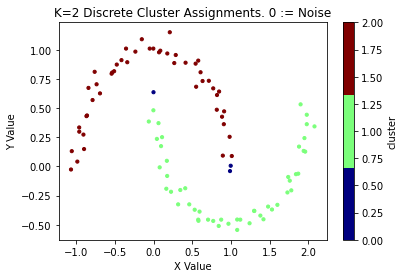

In [185]:
# Plot each cluster
df_dbscan['cluster'] = s_cluster_assignment

fig, ax = plt.subplots()
cmap = plt.get_cmap('jet', 3)
df_dbscan.plot(kind='scatter', x='x', y='y', s=10, c='cluster', colormap=cmap, ax=ax)
# title and axis labels
plt.title("K=2 Discrete Cluster Assignments. 0 := Noise")
plt.xlabel("X Value")
plt.ylabel("Y Value")

## Q2.5 Compare your results to the scikit-learn library

Import DBSCAN from scikit-learn and compare the cluster labels from your implementation to the cluster labels generated from [scikit-learn's DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html). Add some commentary about how you think the results compare. Use the same data and values for eps and minPts.

In [194]:
# check your implementation vs scikit-learn
from sklearn.cluster import DBSCAN
# use same parameters. drop 'cluster' from df_dbscan, which was appended above
clustering = DBSCAN(eps=0.23, min_samples=6).fit( df_dbscan.drop(['cluster'], axis=1) )
sklearn_df = df_dbscan.join(pd.DataFrame(clustering.labels_+1, columns=["sklearn_cluster"]))
print("noise-only slice:")
print(sklearn_df[sklearn_df['cluster'] == 0])
print("\nfull df and value counts:")
print(sklearn_df)
pd.DataFrame(clustering.labels_+1).value_counts()

noise-only slice:
          x        y  cluster  sklearn_cluster
33  0.98700 -0.03970        0                0
36  0.99600  0.00596        0                0
67 -0.00276  0.63600        0                0

full df and value counts:
          x      y  cluster  sklearn_cluster
0   1.08000 -0.544        1                1
1   0.84100 -0.510        1                1
2   0.96700 -0.491        1                1
3   1.24000 -0.487        1                1
4   0.77000 -0.467        1                1
..      ...    ...      ...              ...
95 -0.00477  1.010        2                2
96 -0.35800  1.010        2                2
97 -0.05180  1.010        2                2
98 -0.15400  1.090        2                2
99  0.20800  1.150        2                2

[100 rows x 4 columns]


1    49
2    48
0     3
dtype: int64

***Commentary:*** In this case, the sklearn implementation and my from-scratch implementation yield the exact same results, as we see in the above. I think that due to DBSCAN"s rigid nature, the results only would have differed if I had picked a different starting point for the sklearn version, but I'm not sure if even this is correct.